## 1. Importing packages

In [10]:
import os
import os.path as osp
import sys
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data loading and preprocessing

### 2.1 Load dose matrix

In [11]:
dose_unit = pd.read_excel('DoseMatrix.xlsx', index_col = 0)
dose_matrix = dose_unit.to_numpy()
dose_matrix.shape

(400, 60)

### 2.2 Classify voxels

In [12]:
### Find the index of each structure

def idx2pos(r, c):
    
    return 20 * r + c

def pos2idx(pos):
    
    r, c = divmod(pos, 20)

    return (r, c)


## not index, need to minus 1
## Bladder (5, 9-13), (6, 8-14), (7, 8-14), (8, 9-13)
bladder_idx = []
for c in range(8, 13):
    bladder_idx.append(idx2pos(4, c))
for c in range(7, 14):
    bladder_idx.append(idx2pos(5, c))
for c in range(7, 14):
    bladder_idx.append(idx2pos(6, c))
for c in range(8, 13):
    bladder_idx.append(idx2pos(7, c))


## Rectum (13, 9-13), (14, 9-13), (15, 9-13), (16, 9-13)
rectum_idx = []
for r in range(12, 16):
    for c in range(8, 13):
        rectum_idx.append(idx2pos(r, c))


## Right femur head (6, 3-4), (7, 3-4), (8, 3-4), (9, 3-4), (10, 3-4), (11, 3-4), (12, 3-4), (13, 3-4)
right_femur = []
for r in range(5, 13):
    for c in range(2, 4):
        right_femur.append(idx2pos(r, c))
        
    



## Lefr femur head (6, 17-18), (7, 17-18), (8, 17-19), (9, 17-19), (10, 17-19), (11, 17-19), (12, 17-18), (12, 18)
left_femur = []
for r in range(5, 13):
    
    if r < 7 or r == 11:
        for c in range(16, 18):
            left_femur.append(idx2pos(r, c))
            
    elif 7 <= r <= 10:
        for c in range(16, 19):
            left_femur.append(idx2pos(r, c))
    else:
        left_femur.append(idx2pos(r, 17))
        
        


## CTV (9, 8-14), (10, 7-15), (11, 7-15), (12, 8-14)
ctv_idx = []
for r in range(8, 12):
    
    if r == 8 or r == 11:
        for c in range(7, 14):
            ctv_idx.append(idx2pos(r, c))
            
    else:
        for c in range(6, 15):
            ctv_idx.append(idx2pos(r, c))

## Unspecified everywhere else
other_idx = []
for i in range(400):
    if (not i in ctv_idx) and (not i in left_femur) and (not i in right_femur) and (not i in bladder_idx) and (not i in rectum_idx):
        other_idx.append(i)
print(len(other_idx))


289


### 2.3 Visualization

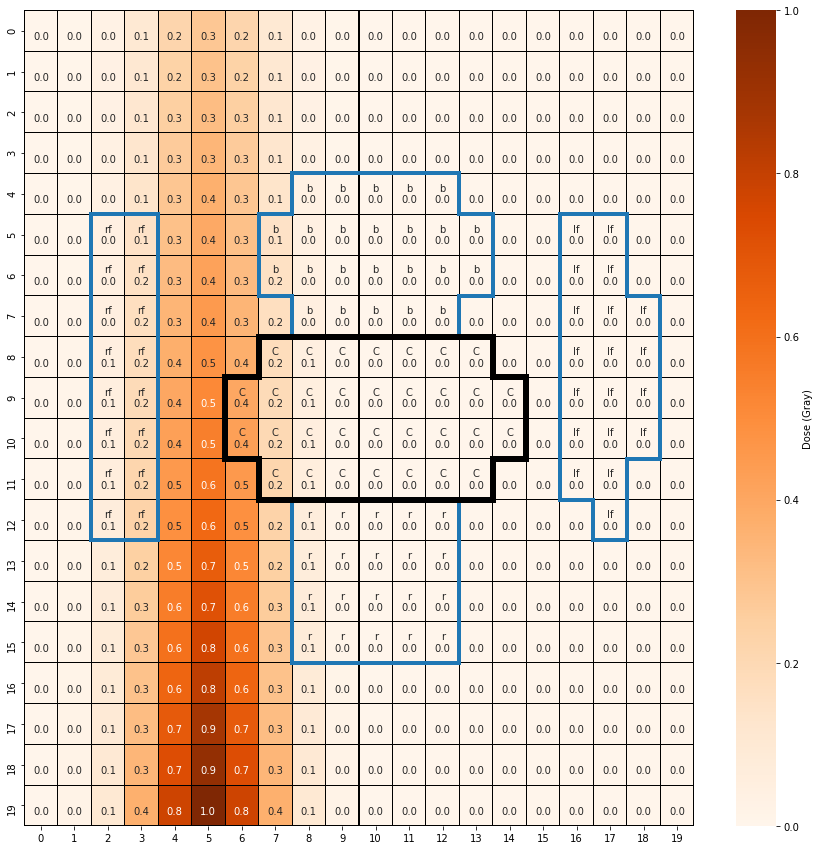

In [13]:
### get dose for a voxel
def get_amount(pos, matrix, dose):
    '''
    Get dose for a position
    '''
    amount = np.dot(matrix[pos, :], dose)
    
    return amount
    

## get labels
labels = [[None] * 20 for _ in range(20)]


for r in range(20):
    for c in range(20):
        
        pos = idx2pos(r, c)
        if pos in bladder_idx:
            labels[r][c] = 'b'
        elif pos in rectum_idx:
            labels[r][c]= 'r'
        elif pos in right_femur:
            labels[r][c] = 'rf'
        elif pos in left_femur:
            labels[r][c] = 'lf'
        elif pos in ctv_idx:
            labels[r][c] = 'C'
        else:
            labels[r][c] = ''
            
labels = np.asarray(labels)

def show_grid(matrix, text, size = (15, 15), save = None):
    '''
    Show dose
    '''
    plt.figure(figsize = size)
    labels = (np.asarray(["{0}\n{1:.1f}".format(text,data) for text, data in zip(text.flatten(), matrix.flatten())])).reshape(20, 20)
    ax = sns.heatmap(matrix, annot = labels, fmt='', \
                     cbar_kws={'label': 'Dose (Gray)'}, linewidth = 0.01, linecolor = 'black', cmap = 'Oranges')
    
    
    ## draw boundary
    # right femur
    plt.axvline(2, 0.35, 0.75, linewidth = 4)
    plt.axvline(4, 0.35, 0.75, linewidth = 4)
    plt.axhline(5, 0.1, 0.2, linewidth = 4)
    plt.axhline(13, 0.1, 0.2, linewidth = 4)
    
    # left femur
    plt.axvline(16, 0.4, 0.75, linewidth = 4)
    plt.axvline(17, 0.35, 0.4, linewidth = 4)
    plt.axvline(19, 0.45, 0.65, linewidth = 4)
    plt.axvline(18, 0.35, 0.45, linewidth = 4)
    plt.axvline(18, 0.65, 0.75, linewidth = 4)
    plt.axhline(13, 0.85, 0.9, linewidth = 4)
    plt.axhline(5, 0.8, 0.9, linewidth = 4)
    plt.axhline(12, 0.8, 0.85, linewidth = 4)
    plt.axhline(7, 0.9, 0.95, linewidth = 4)
    plt.axhline(11, 0.9, 0.95, linewidth = 4)
    
    # bladder
    plt.axhline(4, 0.4, 0.65, linewidth = 4)
    plt.axhline(8, 0.4, 0.65, linewidth = 4)
    plt.axhline(5, 0.35, 0.4, linewidth = 4)
    plt.axhline(5, 0.65, 0.7, linewidth = 4)
    plt.axhline(7, 0.35, 0.4, linewidth = 4)
    plt.axhline(7, 0.65, 0.7, linewidth = 4)
    plt.axvline(7, 0.65, 0.75, linewidth = 4)
    plt.axvline(14, 0.65, 0.75, linewidth = 4)
    plt.axvline(8, 0.6, 0.65, linewidth = 4)
    plt.axvline(8, 0.75, 0.8, linewidth = 4)
    plt.axvline(13, 0.6, 0.65, linewidth = 4)
    plt.axvline(13, 0.75, 0.8, linewidth = 4)
    
    # rectum
    plt.axhline(12, 0.4, 0.65, linewidth = 4)
    plt.axhline(16, 0.4, 0.65, linewidth = 4)
    plt.axvline(8, 0.2, 0.4, linewidth = 4)
    plt.axvline(13, 0.2, 0.4, linewidth = 4)
    
    # ctv
    plt.axhline(8, 0.35, 0.7, linewidth = 6, c = 'black')
    plt.axhline(12, 0.35, 0.7, linewidth = 6, c = 'black')
    plt.axhline(9, 0.3, 0.35, linewidth = 6, c = 'black')
    plt.axhline(11, 0.3, 0.35, linewidth = 6, c = 'black')
    plt.axhline(9, 0.7, 0.75, linewidth = 6, c = 'black')
    plt.axhline(11, 0.7, 0.75, linewidth = 6, c = 'black')
    plt.axvline(6, 0.45, 0.55, linewidth = 6, c = 'black')
    plt.axvline(15, 0.45, 0.55, linewidth = 6, c = 'black')
    plt.axvline(7, 0.4, 0.45, linewidth = 6, c = 'black')
    plt.axvline(7, 0.55, 0.6, linewidth = 6, c = 'black')
    plt.axvline(14, 0.4, 0.45, linewidth = 6, c = 'black')
    plt.axvline(14, 0.55, 0.6, linewidth = 6, c = 'black')
    
    if save is not None:
        plt.savefig(osp.join('imgs', save))
    plt.show()
    plt.close()
    
show_grid(dose_matrix[:, 0].reshape(20, 20), labels) 

Show intensity of beamlets

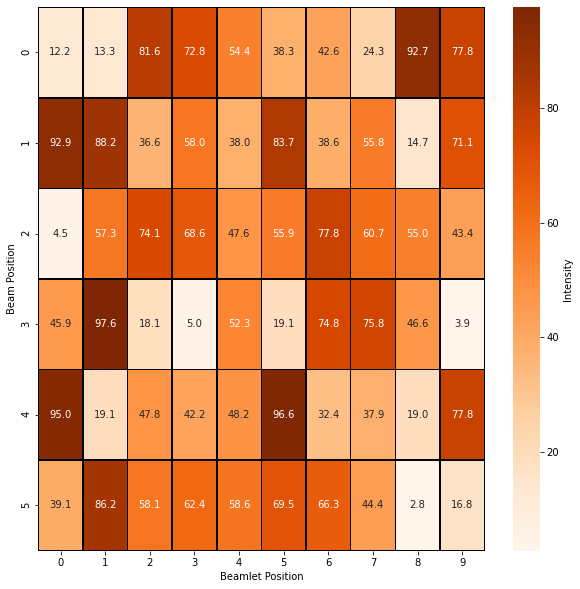

In [16]:
def show_int(dose, size = (10, 10), save = None):
    
    '''Show intensity of beamlets'''
    plt.figure(figsize = size)


    ax = sns.heatmap(dose.reshape(6, 10), linewidth = 0.5,linecolor = 'black', cmap ='Oranges', annot = True, fmt = '.1f', cbar_kws = {'label': 'Intensity'})
    plt.xlabel('Beamlet Position')
    plt.ylabel('Beam Position')
    
    if save is not None:
        plt.savefig(osp.join('imgs', save))
    plt.show()
    plt.close()
    
show_int(np.random.rand(60) * 100)

## 3. Solving

### 3.1 Create solver function

In [17]:
## hypermeters
CTV_MAX = 82.8 + 2
CTV_MIN = 82.8 - 3

BLADDER_MAX = 81 + 4
BLADDER_AVG = 50 + 4
BLADDER_PER = 0.1 + 0.2

RECTUM_MAX = 79.2 + 3
RECTUM_AVG = 40 + 10

UNSPECIFIED_MAX = 72.0 + 5

LF_MAX = 50 + 10
LF_PER = 0.15 + 0.3

RF_MAX = 50 + 10
RF_PER = 0.15 + 0.3


def get_answer(solver_name, obj = 'max', save = None):
    ### 1. Initialize the solver
    solver = pywraplp.Solver(solver_name, 
                             pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    ### 2. Objective
    objective = solver.Objective()
    
    if obj == 'max':
        
        objective.SetMaximization()
    else:
        
        objective.SetMinimization()

    ### 3. Decision variables
    X = [None] * 60
    for i in range(len(X)):

        X[i] = solver.NumVar(0, solver.infinity(), 'x'+str(i))

    ## coefficients for objective
    if obj == 'max':
        
        for i in range(60):
            objective.SetCoefficient(X[i], np.sum(dose_matrix[ctv_idx, i]))
    else:
        else_idx = [i for i in range(400) if i not in ctv_idx]
        for i in range(60):
            
            objective.SetCoefficient(X[i], np.sum(dose_matrix[else_idx, i]))


    ### 4. Constraints

    ####################### CTV
    ## ctv uniform constraints: each should be less than 82.8 * 1.05

    ctv_uniform = [None] * 400
    for pos in ctv_idx:
        ctv_uniform[pos] = solver.Constraint(CTV_MIN, CTV_MAX, 'ctv-uniform' + str(pos))
        for i in range(60):
            ctv_uniform[pos].SetCoefficient(X[i], dose_matrix[pos, i])

    #######################

    ####################### Bladder
    ### bladder
    ## bladder max constraint
    bladder_max = [None] * 400
    for pos in bladder_idx:
        bladder_max[pos] = solver.Constraint(0, BLADDER_MAX, 'bladder-max' + str(pos))
        for i in range(60):
            bladder_max[pos].SetCoefficient(X[i], dose_matrix[pos, i])

    ## bladder avg
    bladder_total = solver.Constraint(0, BLADDER_AVG * len(bladder_idx), 'bladder-total')
    for i in range(60):
        bladder_total.SetCoefficient(X[i], np.sum(dose_matrix[bladder_idx, i]))

    bla_b = {}
    bla_off = {}
    for pos in bladder_idx:

        bla_b[pos] = solver.IntVar(0, 1, 'bla-b' + str(pos))
        bla_off[pos] = solver.NumVar(-solver.infinity(), BLADDER_MAX - 65, 'bla-off' + str(pos))

    ## link beamlets and offset
    bladder_per = {}
    for pos in bladder_idx:
        bladder_per[pos] = solver.Constraint(65, 65)
        # coe for offset
        bladder_per[pos].SetCoefficient(bla_off[pos], -1)

        # coe for beamleat
        for i in range(60):
            bladder_per[pos].SetCoefficient(X[i], dose_matrix[pos, i])

    ## <= 10% 
    bladder_num = solver.Constraint((1 - BLADDER_PER) * len(bladder_idx), len(bladder_idx), 'bla-num')
    bla_off_max = {}
    bla_off_min = {}
    for pos in bladder_idx:
        bladder_num.SetCoefficient(bla_b[pos], 1)

        ## link offset and binary
        bla_off_max[pos] = solver.Constraint(- solver.infinity(), BLADDER_MAX - 65, 'bla-off-max'+ str(pos))
        bla_off_max[pos].SetCoefficient(bla_off[pos], 1)
        bla_off_max[pos].SetCoefficient(bla_b[pos], (BLADDER_MAX - 65.0))

        bla_off_min[pos] = solver.Constraint(0, solver.infinity(), 'bla-off' + str(pos))
        bla_off_min[pos].SetCoefficient(bla_off[pos], 1)
        bla_off_min[pos].SetCoefficient(bla_b[pos], 65)
    #######################       


    ####################### Rectum
    ### rectum
    ## rectum max
    rectum_max = [None] * 400
    for pos in rectum_idx:
        rectum_max[pos] = solver.Constraint(0, RECTUM_MAX, 'rectum-max' + str(pos))
        for i in range(60):
            rectum_max[pos].SetCoefficient(X[i], dose_matrix[pos, i])

    ## rectum avg
    rectum_total = solver.Constraint(0, RECTUM_AVG * len(rectum_idx))
    for i in range(60):
        rectum_total.SetCoefficient(X[i], np.sum(dose_matrix[rectum_idx, i]))

    ####################### 



    ####################### Left Femur Head   

    ## left femur <= 15%
    lf_b = {}
    lf_off = {}
    for pos in left_femur:
        lf_b[pos] = solver.IntVar(0, 1, 'lf-b' + str(pos))
        lf_off[pos] = solver.NumVar(- solver.infinity(), LF_MAX - 40, 'lf-off' + str(pos))

    # link beamlets and offset
    lf_per = {}
    for pos in left_femur:
        lf_per[pos] = solver.Constraint(40, 40)
        # coe for offset
        lf_per[pos].SetCoefficient(lf_off[pos], -1)

        # coe for beamleat
        for i in range(60):
            lf_per[pos].SetCoefficient(X[i], dose_matrix[pos, i])

    lf_num = solver.Constraint((1 - LF_PER) * len(left_femur), len(left_femur), 'lf-num')
    lf_off_max = {}
    lf_off_min = {}
    for pos in left_femur:
        lf_num.SetCoefficient(lf_b[pos], 1)

        ## link offset and binary
        lf_off_max[pos] = solver.Constraint(- solver.infinity(), LF_MAX -40, 'lf-off-max'+ str(pos))
        lf_off_max[pos].SetCoefficient(lf_off[pos], 1)
        lf_off_max[pos].SetCoefficient(lf_b[pos], (LF_MAX - 40))

        lf_off_min[pos] = solver.Constraint(0, solver.infinity(), 'lf-off' + str(pos))
        lf_off_min[pos].SetCoefficient(lf_off[pos], 1)
        lf_off_min[pos].SetCoefficient(lf_b[pos], 40)

    #######################


    ####################### Right Femur Head

    ## right femur <= 15%
    rf_b = {}
    rf_off = {}
    for pos in right_femur:
        rf_b[pos] = solver.IntVar(0, 1, 'rf-b' + str(pos))
        rf_off[pos] = solver.NumVar(- solver.infinity(), RF_MAX - 40, 'rf-off' + str(pos))

    # link beamlets and offset
    rf_per = {}
    for pos in right_femur:

        rf_per[pos] = solver.Constraint(40, 40)
        # coe for offset
        rf_per[pos].SetCoefficient(rf_off[pos], -1)

        # coe for beamleat
        for i in range(60):
            rf_per[pos].SetCoefficient(X[i], dose_matrix[pos, i])

    rf_num = solver.Constraint((1 - RF_PER) * len(right_femur), len(right_femur), 'rf-num')
    rf_off_max = {}
    rf_off_min = {}
    for pos in right_femur:
        rf_num.SetCoefficient(rf_b[pos], 1)

        ## link offset and binary
        rf_off_max[pos] = solver.Constraint(- solver.infinity(), RF_MAX -40, 'rf-off-max'+ str(pos))
        rf_off_max[pos].SetCoefficient(rf_off[pos], 1)
        rf_off_max[pos].SetCoefficient(rf_b[pos], (RF_MAX - 40))

        rf_off_min[pos] = solver.Constraint(0, solver.infinity(), 'rf-off' + str(pos))
        rf_off_min[pos].SetCoefficient(rf_off[pos], 1)
        rf_off_min[pos].SetCoefficient(rf_b[pos], 40)    

    #######################


    ####################### Unspecified
    ### unspecified
    un_max = [None] * 400
    for pos in other_idx:
        un_max[pos] = solver.Constraint(0, UNSPECIFIED_MAX, 'unspecified-max'+ str(pos))

        for i in range(60):
            un_max[pos].SetCoefficient(X[i], dose_matrix[pos, i])

    #######################            



    ### solve the optimization and return the answer
    status = solver.Solve()

    if status == solver.OPTIMAL:
        print('Problem solved in %f millseconds' % solver.wall_time())

    elif status == solver.FEASIBLE:
        print('Solver did not find an optimal solution, but found a feasible solution')
    else:
        print('Solver did not find a solution.')

    print('The average radiation of CTV: ', objective.Value()/len(ctv_idx))
    print(objective.Value())

    dose = np.zeros(60)
    for i in range(60):
        dose[i] = X[i].solution_value()

    # show_grid(np.dot(dose_matrix, dose).reshape(20, 20), labels, (15, 15))
    # dose
    get_constraints(np.dot(dose_matrix, dose).reshape(400))
    show_grid(np.dot(dose_matrix, dose).reshape(20, 20), labels, save = save)
    
    return dose

Get values of each region

In [19]:
def get_constraints(R):
    """
    matrix: 
    """
    
    ### ctv
    min_ctv = np.min(R[ctv_idx])
    max_ctv = np.max(R[ctv_idx])
    avg_ctv = np.mean(R[ctv_idx])
    dev_ctv = (max_ctv - min_ctv)/(82.8)
    print('CTV: -----------------')
    print('Minimum CTV: {:.2f}'.format(min_ctv))
    print('Maximum CTV: {:.2f}'.format(max_ctv))
    print('Average CTV: {:.2f}'.format(avg_ctv))
    print('Deviation CTV: {:.2f} %'.format(dev_ctv * 100), '\n')
    
    ### bladder
    max_bladder = np.max(R[bladder_idx])
    avg_bladder = np.mean(R[bladder_idx])
    per_bladder = np.sum(R[bladder_idx] > 65.0001)/(len(bladder_idx))
    
    print('Bladder: -----------------')
    print('Maximum Bladder: {:.2f}'.format(max_bladder))
    print('Average Bladder: {:.2f}'.format(avg_bladder))
    print('Percentage > 65.0: {:.2f} %'.format(per_bladder * 100), '\n')
    
    ### rectum
    max_rectum = np.max(R[rectum_idx])
    avg_rectum = np.mean(R[rectum_idx])
    print('Rectum: -----------------')
    print('Maximum Rectum: {:.2f}'.format(max_rectum))
    print('Average Rectum: {:.2f}'.format(avg_rectum), '\n')
    
    ###lf
    max_lf = np.max(R[left_femur])
    per_lf = np.sum(R[left_femur] > 40.0001)/len(left_femur)
    
    print('Left Femur: -----------------')
    print('Maximum LF: {:.2f}'.format(max_lf))
    print('Percentage > 40.0: {:.2f}%'.format(per_lf* 100), '\n')
    
    ###rf
    max_rf = np.max(R[right_femur])
    per_rf = np.sum(R[right_femur] > 40.0001)/len(right_femur)
    
    print('Right Femur: -----------------')
    print('Maximum RF: {:.2f}'.format(max_rf))
    print('Percentage > 40.0: {:.2f}%'.format(per_rf*100), '\n')
    
    ###unspecified
    max_un = np.max(R[other_idx])
    print('Unspecified: -----------------')
    print('Maximum Unspecified: {:.2f}'.format(max_un))

Problem solved in 508.000000 millseconds
The average radiation of CTV:  82.14464331802323
2628.6285861767433
CTV: -----------------
Minimum CTV: 79.80
Maximum CTV: 84.80
Average CTV: 82.14
Deviation CTV: 6.04 % 

Bladder: -----------------
Maximum Bladder: 72.58
Average Bladder: 54.00
Percentage > 65.0: 20.83 % 

Rectum: -----------------
Maximum Rectum: 71.94
Average Rectum: 50.00 

Left Femur: -----------------
Maximum LF: 56.96
Percentage > 40.0: 42.11% 

Right Femur: -----------------
Maximum RF: 60.00
Percentage > 40.0: 31.25% 

Unspecified: -----------------
Maximum Unspecified: 77.00


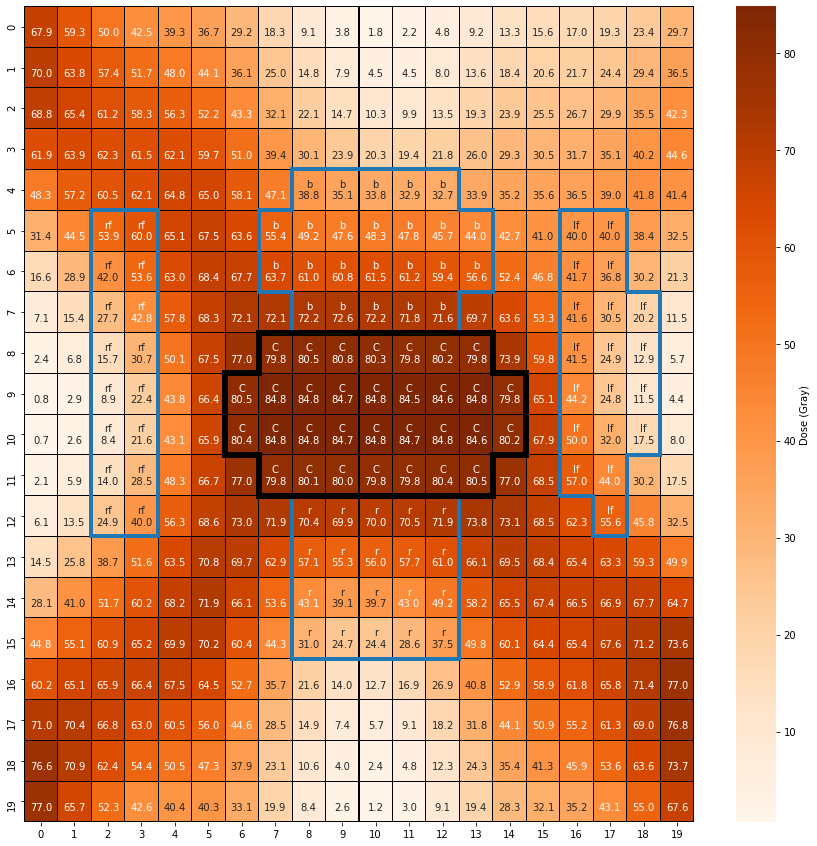

In [20]:
dose = get_answer('try', 'max')

## 4. Results

### 4.1 Plan A

Problem solved in 11274.000000 millseconds
The average radiation of CTV:  82.60343765549496
2643.3100049758386
CTV: -----------------
Minimum CTV: 80.80
Maximum CTV: 84.80
Average CTV: 82.60
Deviation CTV: 4.83 % 

Bladder: -----------------
Maximum Bladder: 74.67
Average Bladder: 58.89
Percentage > 65.0: 25.00 % 

Rectum: -----------------
Maximum Rectum: 76.19
Average Rectum: 55.00 

Left Femur: -----------------
Maximum LF: 47.65
Percentage > 40.0: 10.53% 

Right Femur: -----------------
Maximum RF: 47.30
Percentage > 40.0: 12.50% 

Unspecified: -----------------
Maximum Unspecified: 82.00


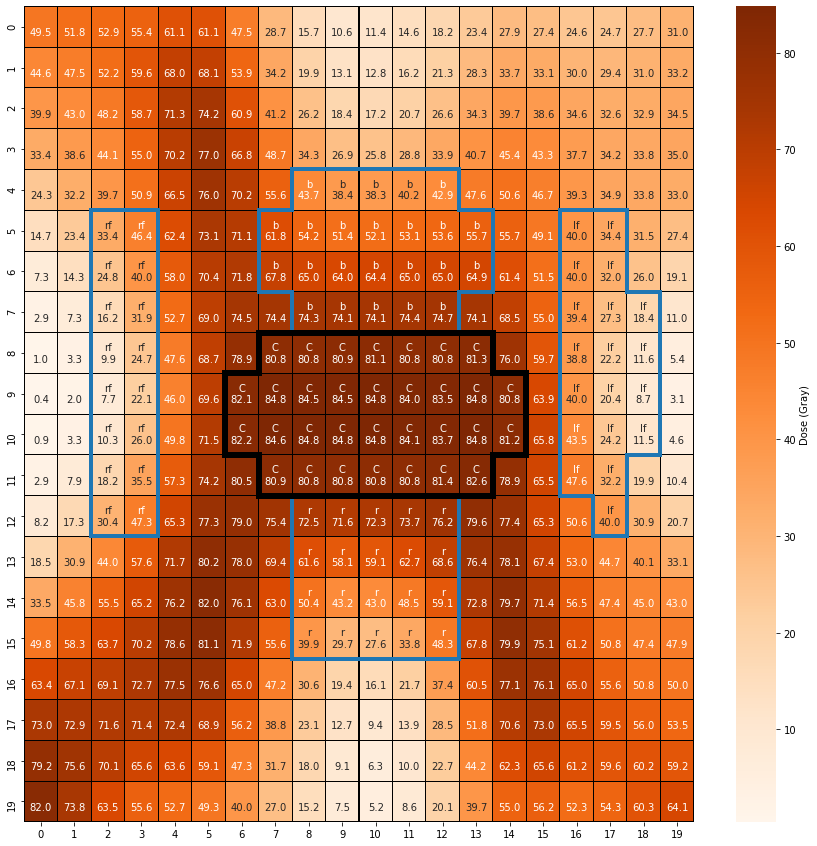

In [21]:
CTV_MAX = 82.8 + 2
CTV_MIN = 82.8 - 2

BLADDER_MAX = 81
BLADDER_AVG = 50 + 10
BLADDER_PER = 0.1 + 0.15

RECTUM_MAX = 79.2
RECTUM_AVG = 40 + 15

UNSPECIFIED_MAX = 72.0 + 10

LF_MAX = 50
LF_PER = 0.15

RF_MAX = 50
RF_PER = 0.15
dose_a = get_answer('plan-a', 'max')

### 4.2 Plan B

Problem solved in 2544.000000 millseconds
The average radiation of CTV:  506.5000721585487
16208.002309073558
CTV: -----------------
Minimum CTV: 79.00
Maximum CTV: 85.80
Average CTV: 82.11
Deviation CTV: 8.21 % 

Bladder: -----------------
Maximum Bladder: 75.51
Average Bladder: 56.02
Percentage > 65.0: 20.83 % 

Rectum: -----------------
Maximum Rectum: 71.75
Average Rectum: 45.00 

Left Femur: -----------------
Maximum LF: 48.86
Percentage > 40.0: 10.53% 

Right Femur: -----------------
Maximum RF: 53.22
Percentage > 40.0: 12.50% 

Unspecified: -----------------
Maximum Unspecified: 83.00


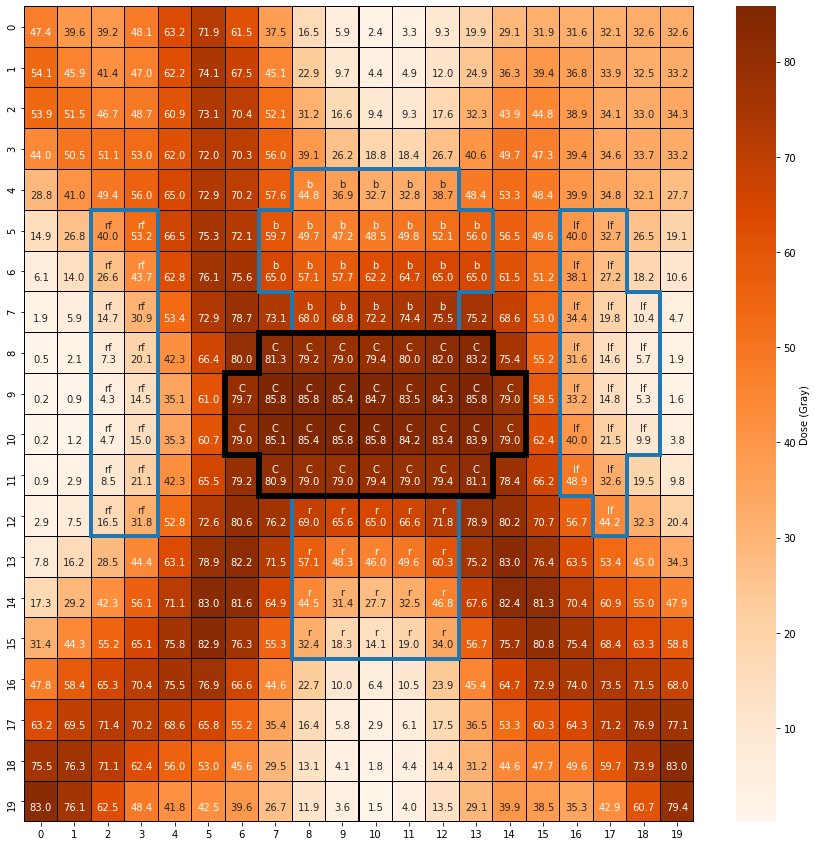

In [22]:
CTV_MAX = 82.8 + 3
CTV_MIN = 82.8 - 3.8


BLADDER_MAX = 81
BLADDER_AVG = 50 + 10
BLADDER_PER = 0.1 + 0.11


RECTUM_MAX = 79.2
RECTUM_AVG = 40 + 5

UNSPECIFIED_MAX = 72.0 + 11

LF_MAX = 50 + 5
LF_PER = 0.15

RF_MAX = 50 + 5
RF_PER = 0.15

dose_b = get_answer('plan-b', 'min')

### 4.3 Plan C

Problem solved in 2451.000000 millseconds
The average radiation of CTV:  482.3655390186333
15435.697248596265
CTV: -----------------
Minimum CTV: 79.80
Maximum CTV: 85.80
Average CTV: 82.12
Deviation CTV: 7.25 % 

Bladder: -----------------
Maximum Bladder: 74.42
Average Bladder: 57.00
Percentage > 65.0: 25.00 % 

Rectum: -----------------
Maximum Rectum: 72.44
Average Rectum: 54.68 

Left Femur: -----------------
Maximum LF: 49.09
Percentage > 40.0: 10.53% 

Right Femur: -----------------
Maximum RF: 44.54
Percentage > 40.0: 12.50% 

Unspecified: -----------------
Maximum Unspecified: 77.00


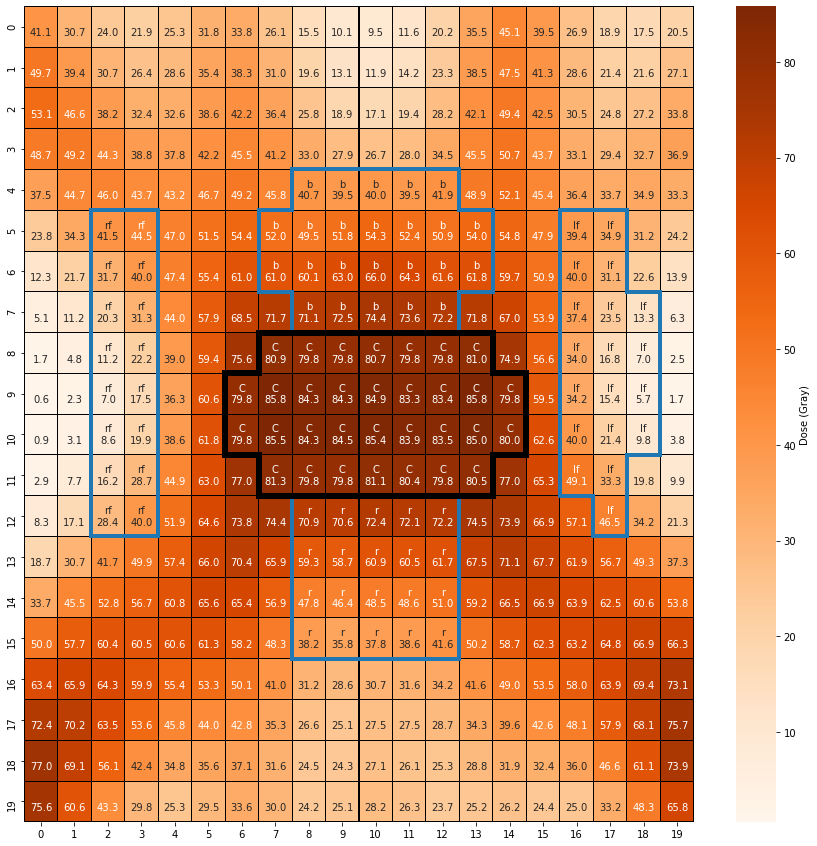

In [23]:
CTV_MAX = 82.8 + 3
CTV_MIN = 82.8 - 3


BLADDER_MAX = 81
BLADDER_AVG = 50 + 7
BLADDER_PER = 0.1 + 0.15


RECTUM_MAX = 79.2
RECTUM_AVG = 40 + 15

UNSPECIFIED_MAX = 72.0 + 5

LF_MAX = 50
LF_PER = 0.15

RF_MAX = 50
RF_PER = 0.15

dose_c = get_answer('plan-c', 'min')

In [29]:
print(list(dose_a), '\n')
print(list(dose_b), '\n')
print(list(dose_c), '\n')

[15.868387093681749, 0.0, 11.177228302249707, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.91976141874853, 0.0, 0.0, 0.0, 28.091865730062302, 7.4874071119776, 34.15204155197002, 0.0, 0.0, 47.17733256643227, 0.0, 0.0, 18.8947209304184, 13.463645592256137, 0.0, 7.4011140440763565, 7.651046210069164, 0.0, 0.0, 0.0, 0.0, 5.197716439959529, 0.0, 1.429804646924821, 10.044500687093013, 0.0, 0.0, 3.9339655880369704, 0.3985800650851688, 0.0, 33.67009823297649, 0.0, 0.0, 0.0, 35.317475126183076, 7.2369777536785085, 0.0, 18.59593851359447, 11.402504940355886, 0.0, 0.0, 0.0, 0.0, 49.531412429384005, 0.0, 38.44589656715621, 17.06318883705735, 26.36388056882432, 6.802124917796154, 0.0, 0.0] 

[0.0, 24.409343099299715, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.389018509085226, 0.0, 0.0, 0.0, 0.0, 7.196435447855121, 65.80228283004259, 0.0, 15.675279233664055, 35.68303433132794, 0.0, 0.0, 0.0, 26.679569500334193, 1.940489862954584, 0.0, 3.6276469318478264, 16.155952837462006, 0.0, 0.0, 0.0, 10.64712777928269, 0.678384